In [1]:
import rasterio as ro
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import random
import math
import pandas
from scipy import optimize

#from keras_tuner.engine.hyperparameters import HyperParameters

from scipy.signal import savgol_filter

In [2]:
# load the data
ndvi = ro.open("Data/NDVI.grd")

covariates = ro.open("Data/covariates_250m_peninsula.grd")

p1 = ro.open("Data/newprec_01.tif")

p7 = ro.open("Data/newprec_07.tif")

fire_history = ro.open("Data/age.grd")

qa_data = ro.open("Data/QA.grd")

In [3]:
# read the shape of covariates
covariates_arr = covariates.read()

np.shape(covariates_arr)

(12, 172, 63)

In [4]:
# read the shape of NDVI
ndvi_arr = ndvi.read()

np.shape(ndvi_arr)

(748, 172, 63)

In [5]:
# read the shape of QA
qa_arr = qa_data.read()

np.shape(qa_arr)

(748, 172, 63)

In [6]:
# read the shape of fire history
fire_arr = fire_history.read()

np.shape(fire_arr)

(748, 172, 63)

In [7]:
# read the precipitation data
p1_arr = p1.read()
p1_arr.shape
p7_arr = p7.read()
p7_arr.shape

p1_arr = p1_arr[:,:172,:63]

p7_arr = p7_arr[:,:172,:63]

In [8]:
p1_arr.shape

(1, 172, 63)

In [9]:
# replace the negative value with nan data in precipitation
for m in range(0,172):
  for n in range(0,63):
    if p1_arr[:,m,n] < 0 :
      p1_arr[:,m,n] = np.nan
    else:
      pass


for m in range(0,172):
  for n in range(0,63):
    if p7_arr[:,m,n] < 0 :
      p7_arr[:,m,n] = np.nan
    else:
      pass

In [10]:
# replace the precipitation value
covariates_arr[9] = p1_arr
covariates_arr[10] = p7_arr

In [11]:
# read the shape of new covariates 
np.shape(covariates_arr)

(12, 172, 63)

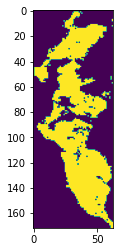

In [12]:
# create a mask based on the environmental variables and fire history
study_region_mask = np.zeros((ndvi.height,ndvi.width))


for i in range(study_region_mask.shape[0]):
    for j in range(study_region_mask.shape[1]):
        found_nan = False
        for var_index in range(covariates_arr.shape[0]):
            if np.isnan(covariates_arr[var_index,i,j]):
                found_nan =True
                break

        for time_step in range(fire_arr.shape[0]):
            if np.isnan(fire_arr[time_step,i,j]):
                found_nan =True
                break
        
        if found_nan:
            study_region_mask[i,j] = -1
        else:
            study_region_mask[i,j] = 1

plt.imshow(study_region_mask)

In [13]:
nan_value = 0

In [14]:
# a mask out function
def mask_layer(input_layer, mask_layer):
    for i in range(mask_layer.shape[0]):
        for j in range(mask_layer.shape[1]):
            if mask_layer[i,j]==-1:
                input_layer[i,j] = nan_value # replace the nan value in the input data

    return input_layer

In [15]:
#savgol_filter to smooth the data
#ndvi_times = range(1,ndvi.count+1)

qa_value_array = qa_data.read()

ndvi_smoothed = []

for m in range(0,ndvi.height):
  for n in range(0,ndvi.width):

    ndvi_ori = ndvi_arr[:,m,n]
    
    if study_region_mask[m,n] ==-1:
      ndvi_smoothed.append(ndvi_ori)
      continue
    
    
    qa_value = qa_arr[:,m,n]
    # for i in ndvi_times:
    #   ndvi_data = ndvi.read(i)
    #   ndvi_pixel = ndvi_data[m,n]
    #   ndvi_ori.append(ndvi_pixel)


    #   qa = qa_data.read(i)
    #   qa_pixel = qa[m,n]
    #   qa_value.append(qa_pixel)

    smoothed = savgol_filter(ndvi_ori,7,2)

    for t in range(qa_value.shape[0]):
      if qa_value[t] == 0 and ndvi_ori[t]>0:
        smoothed[t] = ndvi_ori[t]
      # else:
      #   pass

    ndvi_smoothed.append(smoothed)


ndvi_smoothed = np.asarray(ndvi_smoothed)

In [16]:
np.shape(ndvi_smoothed)

(10836, 748)

In [17]:
# created the dataset contains ONLY SMOOTHED NDVI DATA
smoothed_dataset = np.zeros((ndvi.count,ndvi.height,ndvi.width,1))
for time_steps in range(0,ndvi.count):
  for m in range(0,ndvi.height):
    for n in range(0,ndvi.width):
      smoothed_dataset[time_steps,m,n,0] = ndvi_smoothed[63*m+n][time_steps]

print(np.shape(smoothed_dataset))

(748, 172, 63, 1)


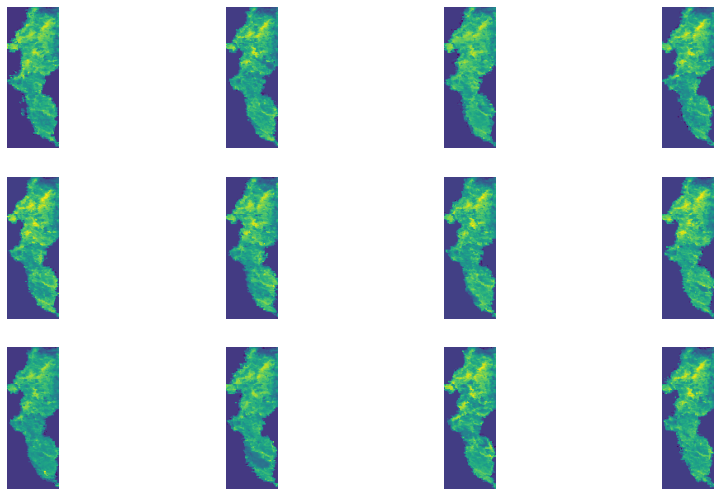

In [18]:
# visualize random 12 NDVI values of SMOOTHED NDVI DATASET
plt.figure(figsize=(15,12))
for i in range(1,13):
    plt.subplot(4,4,i)
    random_time = random.randint(0,ndvi.count-1)
    plt.imshow(smoothed_dataset[random_time,:,:,0])
    plt.axis('off')

In [19]:
# filter the SMOOTHED DATA with the mask

for time_steps in range(0,smoothed_dataset.shape[0]):
    smoothed_dataset[time_steps,:,:,:] = mask_layer(smoothed_dataset[time_steps,:,:,:],study_region_mask)


print(np.shape(smoothed_dataset))

(748, 172, 63, 1)


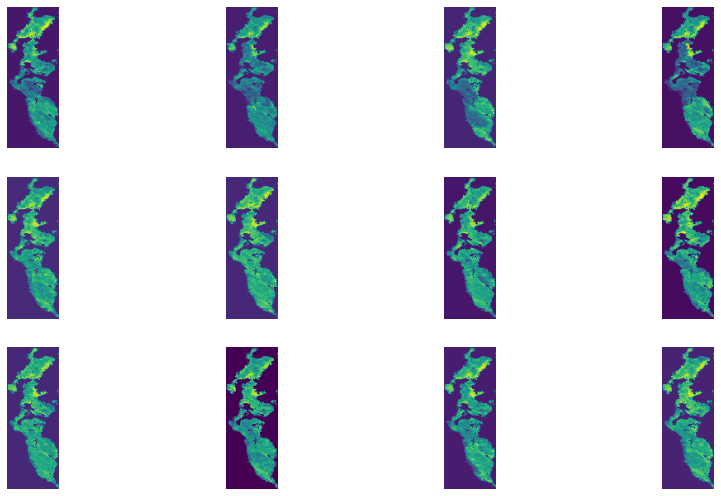

In [20]:
# visualize random 12 NDVI values of SMOOTHED and masked NDVI DATASET
plt.figure(figsize=(15,12))
for i in range(1,13):
    plt.subplot(4,4,i)
    random_time = random.randint(0,ndvi.count-1)
    plt.imshow(smoothed_dataset[random_time,:,:,0])
    plt.axis('off')

convLSTM part

In [21]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

In [22]:
#!!pip install tensorflow

In [23]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [24]:
step_ahead = 46

In [25]:
tf.random.set_seed(42)

In [26]:


def create_model():
    tf.random.set_seed(42)
    np.random.seed(42)

    model = keras.Sequential(
        [
            layers.SimpleRNN(541,return_sequences = True,input_shape=[None, 172*63]),
            layers.SimpleRNN(541,return_sequences = True),
            #layers.SimpleRNN(541,return_sequences = True),
            #layers.SimpleRNN(541,return_sequences = True),
            #layers.SimpleRNN(541),

            layers.TimeDistributed(keras.layers.Dense(172*63*step_ahead))
            #layers.Dense(172*63)#, activation="linear")
        ]
    )
    model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(learning_rate=0.0001))
    return model


In [27]:
series = []
for i in range(0,ndvi.count-15-step_ahead+1):
    this_series_arr = []
    for j in range(0,15+step_ahead):
        this_series = smoothed_dataset[i+j,:,:,:]
        this_series_arr.append(this_series)

    series.append(this_series_arr)

series = np.asarray(series)

print(series.shape)

Y = np.empty((series.shape[0],15,172,63,step_ahead))

for k in range(1, step_ahead + 1):
    Y[:,:,:,:, k - 1] = series[:, k:k + 15,:,:, 0]

X = series[:,:15,:,:,:]

training_size = int(0.75*series.shape[0]) # 561

initial_ndvi = X[:training_size,...]
next_ndvi = Y[:training_size,...]

test_data_input = X[training_size:,...]
test_data_label = Y[training_size:,...]

(688, 61, 172, 63, 1)


In [28]:
initial_ndvi.shape, next_ndvi.shape

((516, 15, 172, 63, 1), (516, 15, 172, 63, 46))

In [29]:
initial_ndvi = initial_ndvi.reshape((next_ndvi.shape[0],15,172*63))

In [30]:
next_ndvi = next_ndvi.reshape((initial_ndvi.shape[0],15,172*63*step_ahead))

In [31]:
initial_ndvi.shape, next_ndvi.shape

((516, 15, 10836), (516, 15, 498456))

In [32]:
def x_generator():
    for i in range(initial_ndvi.shape[0]):
        yield initial_ndvi[i]

In [33]:
def y_generator():
    for i in range(next_ndvi.shape[0]):
        yield next_ndvi[i]

In [34]:
x_dataset = tf.data.Dataset.from_generator(x_generator,output_types=tf.float32)

In [35]:
y_dataset = tf.data.Dataset.from_generator(y_generator,output_types=tf.float32)

In [36]:
combine_dataset = tf.data.Dataset.zip((x_dataset, y_dataset))

In [37]:
combine_batches = combine_dataset.batch(30)

(30, 15, 10836)
(30, 15, 498456)
Epoch 1/70
27/27 [==============================] - 18s 183ms/step - loss: 0.0450 - val_loss: 0.0042
Epoch 2/70
27/27 [==============================] - 5s 169ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 3/70
27/27 [==============================] - 5s 170ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 4/70
27/27 [==============================] - 5s 169ms/step - loss: 0.0024 - val_loss: 0.0033
Epoch 5/70
27/27 [==============================] - 5s 169ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 6/70
27/27 [==============================] - 5s 168ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 7/70
27/27 [==============================] - 5s 169ms/step - loss: 0.0026 - val_loss: 0.0032

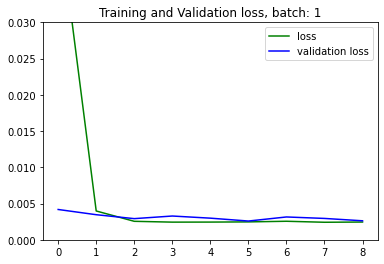

(30, 15, 10836)
(30, 15, 498456)
Epoch 1/70
27/27 [==============================] - 5s 172ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 2/70
27/27 [==============================] - 4s 165ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 3/70
27/27 [==============================] - 5s 168ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 4/70
27/27 [==============================] - 5s 168ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 5/70
27/27 [==============================] - 5s 169ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 6/70
27/27 [==============================] - 5s 168ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 7/70
27/27 [==============================] - 5s 167ms/step - loss: 0.0027 - val_loss: 0.0028
E

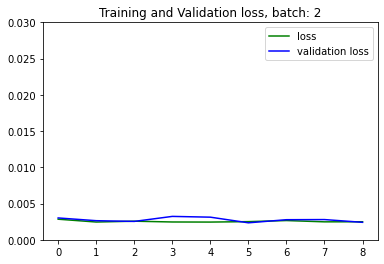

(30, 15, 10836)
(30, 15, 498456)
Epoch 1/70
27/27 [==============================] - 5s 174ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 2/70
27/27 [==============================] - 4s 166ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 3/70
27/27 [==============================] - 5s 168ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 4/70
27/27 [==============================] - 4s 167ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 5/70
27/27 [==============================] - 5s 170ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 6/70
27/27 [==============================] - 4s 165ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 7/70
27/27 [==============================] - 5s 168ms/step - loss: 0.0024 - val_loss: 0.0023
E

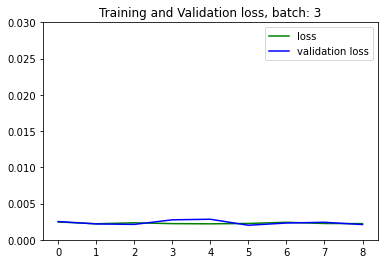

(30, 15, 10836)
(30, 15, 498456)
Epoch 1/70
27/27 [==============================] - 5s 175ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 2/70
27/27 [==============================] - 4s 166ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 3/70
27/27 [==============================] - 4s 166ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 4/70
27/27 [==============================] - 4s 166ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 5/70
27/27 [==============================] - 5s 168ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 6/70
27/27 [==============================] - 4s 167ms/step - loss: 0.0020 - val_loss: 0.0019


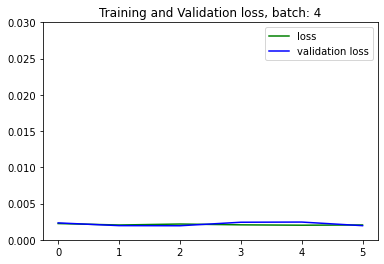

(30, 15, 10836)
(30, 15, 498456)
Epoch 1/70
27/27 [==============================] - 5s 174ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 2/70
27/27 [==============================] - 4s 165ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 3/70
27/27 [==============================] - 5s 171ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 4/70
27/27 [==============================] - 5s 167ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 5/70
27/27 [==============================] - 5s 171ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 6/70
27/27 [==============================] - 4s 165ms/step - loss: 0.0018 - val_loss: 0.0021


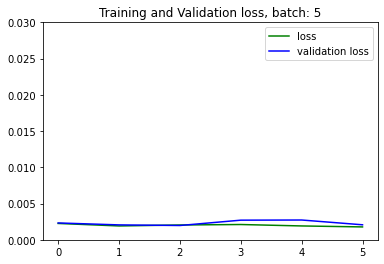

(30, 15, 10836)
(30, 15, 498456)
Epoch 1/70
27/27 [==============================] - 5s 169ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 2/70
27/27 [==============================] - 5s 168ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 3/70
27/27 [==============================] - 4s 164ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 4/70
27/27 [==============================] - 5s 169ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 5/70
27/27 [==============================] - 5s 167ms/step - loss: 0.0020 - val_loss: 0.0031


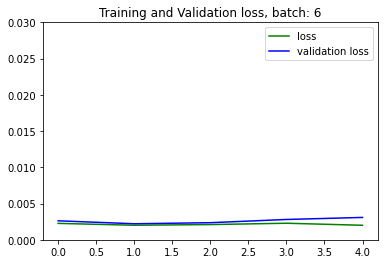

(30, 15, 10836)
(30, 15, 498456)
Epoch 1/70
27/27 [==============================] - 5s 173ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 2/70
27/27 [==============================] - 5s 168ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 3/70
27/27 [==============================] - 5s 167ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 4/70
27/27 [==============================] - 5s 167ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/70
27/27 [==============================] - 4s 167ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 6/70
27/27 [==============================] - 4s 167ms/step - loss: 0.0018 - val_loss: 0.0018


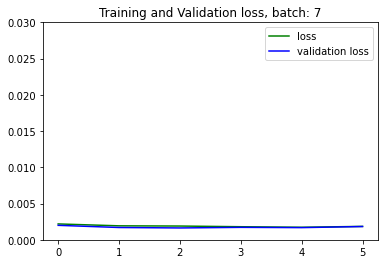

(30, 15, 10836)
(30, 15, 498456)
Epoch 1/70
27/27 [==============================] - 5s 171ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 2/70
27/27 [==============================] - 5s 168ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 3/70
27/27 [==============================] - 4s 167ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 4/70
27/27 [==============================] - 5s 167ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 5/70
27/27 [==============================] - 4s 165ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 6/70
27/27 [==============================] - 5s 169ms/step - loss: 0.0016 - val_loss: 0.0019


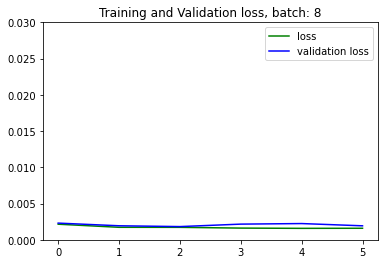

(30, 15, 10836)
(30, 15, 498456)
Epoch 1/70
27/27 [==============================] - 5s 170ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 2/70
27/27 [==============================] - 5s 169ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 3/70
27/27 [==============================] - 4s 164ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 4/70
27/27 [==============================] - 5s 170ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 5/70
27/27 [==============================] - 4s 165ms/step - loss: 0.0019 - val_loss: 0.0033


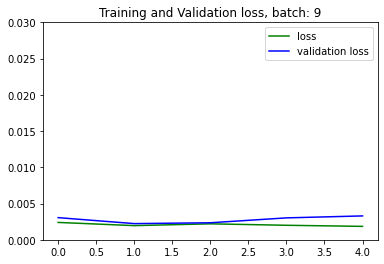

(30, 15, 10836)
(30, 15, 498456)
Epoch 1/70
27/27 [==============================] - 5s 172ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 2/70
27/27 [==============================] - 5s 169ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 3/70
27/27 [==============================] - 4s 164ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 4/70
27/27 [==============================] - 5s 170ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 5/70
27/27 [==============================] - 4s 167ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 6/70
27/27 [==============================] - 5s 171ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 7/70
27/27 [==============================] - 5s 167ms/step - loss: 0.0021 - val_loss: 0.0021
E

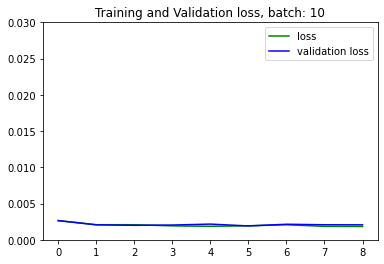

(30, 15, 10836)
(30, 15, 498456)
Epoch 1/70
27/27 [==============================] - 5s 173ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 2/70
27/27 [==============================] - 5s 167ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 3/70
27/27 [==============================] - 5s 168ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 4/70
27/27 [==============================] - 5s 167ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 5/70
27/27 [==============================] - 5s 170ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 6/70
27/27 [==============================] - 5s 167ms/step - loss: 0.0017 - val_loss: 0.0019


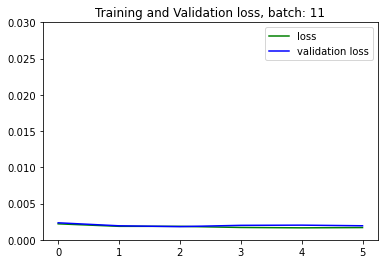

(30, 15, 10836)
(30, 15, 498456)
Epoch 1/70
27/27 [==============================] - 5s 175ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 2/70
27/27 [==============================] - 5s 168ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 3/70
27/27 [==============================] - 5s 168ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 4/70
27/27 [==============================] - 5s 168ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 5/70
27/27 [==============================] - 5s 168ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 6/70
27/27 [==============================] - 5s 170ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 7/70
27/27 [==============================] - 5s 167ms/step - loss: 0.0017 - val_loss: 0.0019
E

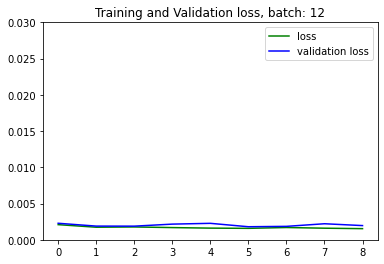

(30, 15, 10836)
(30, 15, 498456)
Epoch 1/70
27/27 [==============================] - 5s 175ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 2/70
27/27 [==============================] - 4s 166ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 3/70
27/27 [==============================] - 5s 170ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 4/70
27/27 [==============================] - 5s 169ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 5/70
27/27 [==============================] - 5s 167ms/step - loss: 0.0018 - val_loss: 0.0025


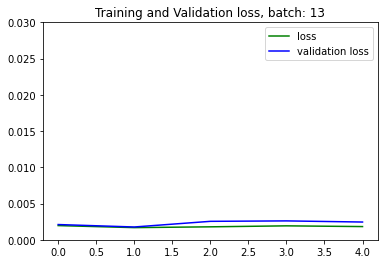

(30, 15, 10836)
(30, 15, 498456)
Epoch 1/70
27/27 [==============================] - 5s 174ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 2/70
27/27 [==============================] - 5s 169ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 3/70
27/27 [==============================] - 5s 169ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 4/70
27/27 [==============================] - 5s 168ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 5/70
27/27 [==============================] - 5s 168ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 6/70
27/27 [==============================] - 4s 164ms/step - loss: 0.0017 - val_loss: 0.0018


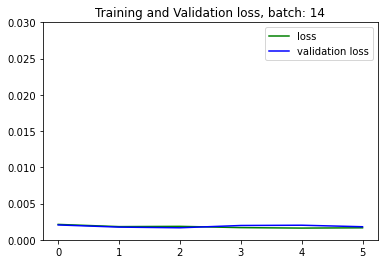

(30, 15, 10836)
(30, 15, 498456)
Epoch 1/70
27/27 [==============================] - 5s 176ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 2/70
27/27 [==============================] - 4s 166ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 3/70
27/27 [==============================] - 5s 169ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 4/70
27/27 [==============================] - 4s 166ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 5/70
27/27 [==============================] - 5s 169ms/step - loss: 0.0015 - val_loss: 0.0020


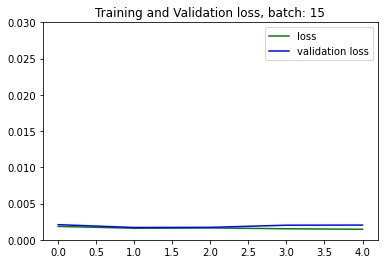

(30, 15, 10836)
(30, 15, 498456)
Epoch 1/70
27/27 [==============================] - 5s 176ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 2/70
27/27 [==============================] - 4s 165ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 3/70
27/27 [==============================] - 5s 167ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 4/70
27/27 [==============================] - 4s 165ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 5/70
27/27 [==============================] - 5s 168ms/step - loss: 0.0020 - val_loss: 0.0029


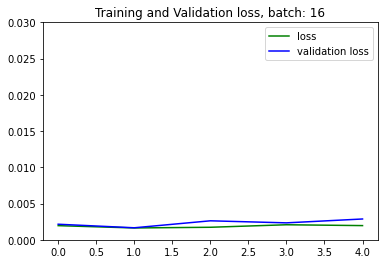

(30, 15, 10836)
(30, 15, 498456)
Epoch 1/70
27/27 [==============================] - 5s 173ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 2/70
27/27 [==============================] - 5s 170ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 3/70
27/27 [==============================] - 4s 166ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 4/70
27/27 [==============================] - 5s 169ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 5/70
27/27 [==============================] - 5s 168ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 6/70
27/27 [==============================] - 5s 169ms/step - loss: 0.0016 - val_loss: 0.0017


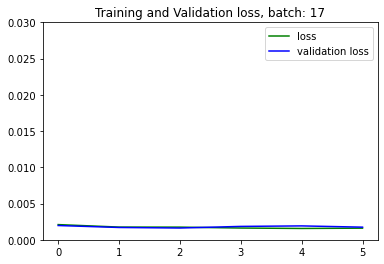

(6, 15, 10836)
(6, 15, 498456)
Epoch 1/70
5/5 [==============================] - 1s 189ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 2/70
5/5 [==============================] - 1s 181ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 3/70
5/5 [==============================] - 1s 189ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 4/70
5/5 [==============================] - 1s 183ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 5/70
5/5 [==============================] - 1s 178ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 6/70
5/5 [==============================] - 1s 177ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 7/70
5/5 [==============================] - 1s 179ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 8/70
5/5 [===============

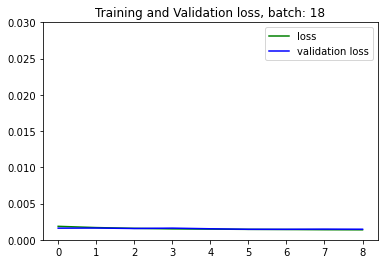

In [38]:
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3)
#Train the model
simpleRNN_model = create_model()

epochs = 70

batch_num = 1

for x,y in combine_batches.take(18):
    print(np.shape([x_arr.numpy() for x_arr in x]))
    print(np.shape([y_arr.numpy() for y_arr in y]))
    history = simpleRNN_model.fit(
        np.asarray([x_arr.numpy() for x_arr in x]),
        np.asarray([y_arr.numpy() for y_arr in y]),
        batch_size=1,
        epochs=epochs,
        verbose=1,
        validation_split=0.1,
        callbacks=[callback]
    )


    loss_train = history.history["loss"]
    loss_val = history.history['val_loss']

    plt.plot(loss_train, 'g', label='loss')
    plt.plot(loss_val, 'b', label='validation loss')
    plt.title('Training and Validation loss, batch: ' + str(batch_num))
    plt.ylim(0,0.03)
    plt.legend()
    plt.show()
    
    batch_num += 1

simpleRNN_model.save('PretrainedModel/SimpleRNN_smoothed_NDVI_only_linear_activation_flatten_46steps.h5')


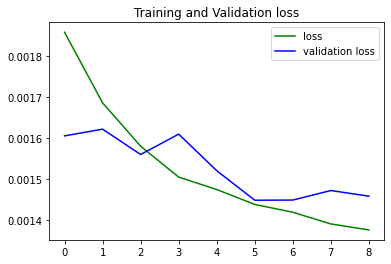

In [39]:
loss_train = history.history["loss"]
loss_val = history.history['val_loss']

plt.plot(loss_train, 'g', label='loss')
plt.plot(loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')

plt.legend()
plt.show()

In [37]:
simpleRNN_model = tf.keras.models.load_model('PretrainedModel/SimpleRNN_smoothed_NDVI_only_linear_activation_flatten_46steps.h5')
simpleRNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 541)         6155498   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 541)         585903    
_________________________________________________________________
time_distributed (TimeDistri (None, None, 498456)      270163152 
Total params: 276,904,553
Trainable params: 276,904,553
Non-trainable params: 0
_________________________________________________________________


In [38]:
"""
# create test dataset using the remaining 25% data 
test_data_input = []
test_data_label = []

for sample_i in range(training_size, ndvi.count):
    
    test_data_label.append(smoothed_dataset[sample_i,:,:,0])
    this_initial_sequence = []
    for t in range(sample_i-15,sample_i): # each sample has 15 time steps
        this_initial = smoothed_dataset[t,:,:,0]
        #this_initial = this_initial[..., np.newaxis]
        this_initial_sequence.append(this_initial)
        
    test_data_input.append(this_initial_sequence)
    
    
test_data_input = np.asarray(test_data_input)
test_data_label = np.asarray(test_data_label)
"""

'\n# create test dataset using the remaining 25% data \ntest_data_input = []\ntest_data_label = []\n\nfor sample_i in range(training_size, ndvi.count):\n    \n    test_data_label.append(smoothed_dataset[sample_i,:,:,0])\n    this_initial_sequence = []\n    for t in range(sample_i-15,sample_i): # each sample has 15 time steps\n        this_initial = smoothed_dataset[t,:,:,0]\n        #this_initial = this_initial[..., np.newaxis]\n        this_initial_sequence.append(this_initial)\n        \n    test_data_input.append(this_initial_sequence)\n    \n    \ntest_data_input = np.asarray(test_data_input)\ntest_data_label = np.asarray(test_data_label)\n'

In [39]:

print(test_data_input.shape)
print(test_data_label.shape)


(172, 15, 172, 63, 1)
(172, 15, 172, 63, 46)


In [40]:
test_data_input = test_data_input.reshape((test_data_label.shape[0],15,172*63))
#test_data_label = test_data_label.reshape(187,172,63)
#test_data_label = test_data_label.reshape(187,172*63)

In [41]:
print(test_data_input.shape)
print(test_data_label.shape)

(172, 15, 10836)
(172, 15, 172, 63, 46)


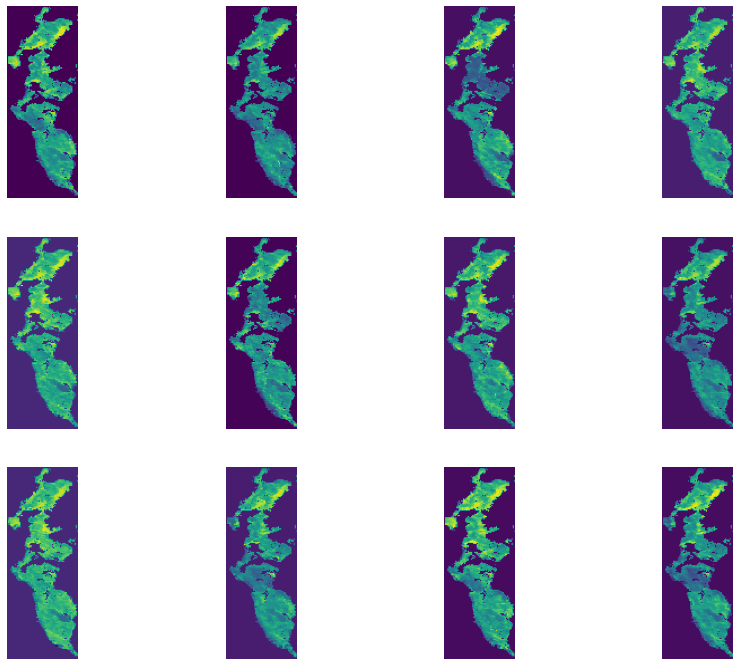

In [42]:
# visualize random 12 test label
plt.figure(figsize=(15,12))
for i in range(1,13):
    plt.subplot(3,4,i)
    random_time = random.randint(0,test_data_label.shape[0])
    plt.imshow(test_data_label[random_time,-1,:,:,-1])
    plt.axis('off')

In [43]:
def test_input_generator():
    for i in range(test_data_input.shape[0]):
        yield test_data_input[i]

def test_label_generator():
    for i in range(test_data_label.shape[0]):
        yield test_data_label[i]

In [44]:
test_input_dataset = tf.data.Dataset.from_generator(test_input_generator,output_types=tf.float32)
test_label_dataset = tf.data.Dataset.from_generator(test_label_generator,output_types=tf.float32)

In [45]:
test_input_batches = test_input_dataset.batch(30) #6 batches
test_label_batches = test_label_dataset.batch(30)

In [46]:
predicition_result = []

for test_input in test_input_batches.take(6):
    a = np.asarray([x_arr.numpy() for x_arr in test_input])
    predicted = simpleRNN_model.predict(a) 
    predicted_reshape = predicted.reshape((predicted.shape[0],15,172,63,step_ahead))
    predicition_result.append(predicted_reshape)

In [47]:
np.shape(predicition_result[5])

(22, 15, 172, 63, 46)

In [48]:
prediction = np.empty((test_data_input.shape[0],15,172,63,step_ahead))

for k in range(5):
    for i in range(30):
        current_prediction_result = predicition_result[k]
        prediction[k*30+i,:,:,:,:] = current_prediction_result[i,:,:,:,:]

sixth_prediction_result = predicition_result[5]
for i in range(22):
    prediction[150+i,:,:,:,:] = sixth_prediction_result [i,:,:,:,:]




In [49]:
predicted = prediction

In [50]:
#np.shape(predicted)
np.shape(predicted)

(172, 15, 172, 63, 46)

In [51]:
predicted = predicted[:,-1,:,:,:]

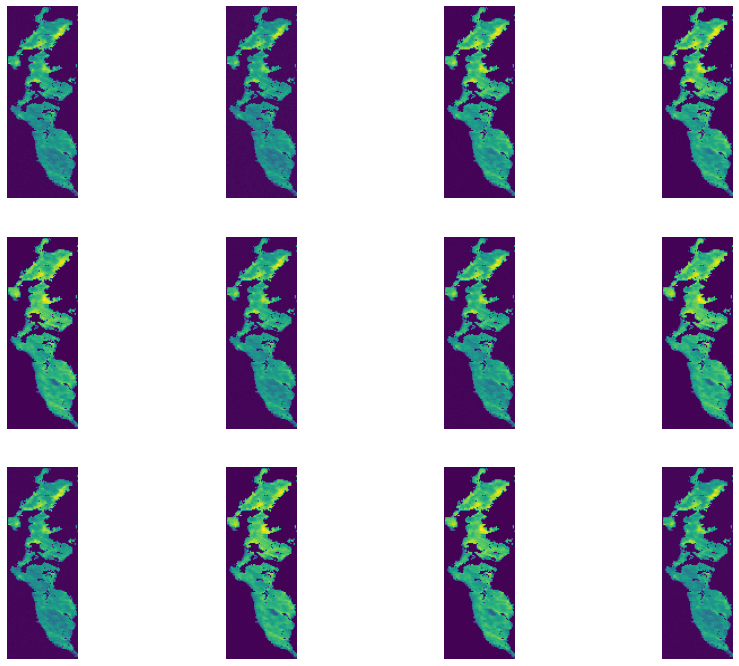

In [52]:
# Visualize some predicted NDVI
plt.figure(figsize=(15,12))
for i in range(1,13):
    plt.subplot(3,4,i)
    random_time = random.randint(0,test_data_label.shape[0])
    plt.imshow(predicted[random_time,:,:,-1])
    plt.axis('off')
    

In [53]:
# find the valid test pixels for RMSE calculation
"""
valid_testlabel = []
valid_predicted = []


for m in range(0,172):
    for n in range(0,63):
        for i in range(initial_ndvi.shape[0],series.shape[0]):

            if qa_arr[i,m,n] == 0 and ndvi_arr[i,m,n]>0 and study_region_mask[m,n] == 1:
                valid_testlabel.append(test_data_label[i-initial_ndvi.shape[0],-1,m,n,:])
                valid_predicted.append(predicted[i-initial_ndvi.shape[0],m,n,:])

print(np.shape(valid_testlabel))
print(np.shape(valid_predicted))
"""

'\nvalid_testlabel = []\nvalid_predicted = []\n\n\nfor m in range(0,172):\n    for n in range(0,63):\n        for i in range(initial_ndvi.shape[0],series.shape[0]):\n\n            if qa_arr[i,m,n] == 0 and ndvi_arr[i,m,n]>0 and study_region_mask[m,n] == 1:\n                valid_testlabel.append(test_data_label[i-initial_ndvi.shape[0],-1,m,n,:])\n                valid_predicted.append(predicted[i-initial_ndvi.shape[0],m,n,:])\n\nprint(np.shape(valid_testlabel))\nprint(np.shape(valid_predicted))\n'

In [54]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error
#from keras_tuner.engine.hyperparameters import HyperParameters
import sklearn
def evaluate_method_performance(labeled_data, predicted, n_training_time_steps):
    n_test_time_steps = labeled_data.shape[0]
    time_step_ahead = labeled_data.shape[3]
    
    valid_label = []
    valid_predicted = []
    
    for t in range(n_test_time_steps):
        for m in range(172):
            for n in range(63):
                for a in range(time_step_ahead):
                    if qa_arr[n_training_time_steps+t+a,m,n] == 0 and ndvi_arr[n_training_time_steps+t+a,m,n]>0 and study_region_mask[m,n] == 1:
                        valid_label.append(labeled_data[t,m,n,a])
                        valid_predicted.append(predicted[t,m,n,a])
                        
    print("R squared is: "+str(sklearn.metrics.r2_score(valid_label,valid_predicted)))
    print("RMSE is: "+str(mean_squared_error(valid_label,valid_predicted, squared=False)))

In [55]:
test_data_label=test_data_label[:,-1,:,:,:]
print(test_data_label.shape)
evaluate_method_performance(test_data_label, predicted,initial_ndvi.shape[0])

(172, 172, 63, 46)
R squared is: 0.3814424904165483
RMSE is: 0.1022555676761095


In [ ]:
# Visualize the predictions of 12 pixels
time_steps = range(training_size+1, training_size+1+len(test_data_label))

fig, axes = plt.subplots(3,4, figsize=(22,14))
fig.tight_layout(pad=4.0)
for i in range(1,13):
    #for j in range(1,3):

    plt.subplot(3,4,i)

    pixel_y = random.randint(0,ndvi.height-1)
    pixel_x = random.randint(0,ndvi.width-1)

    while study_region_mask[pixel_y,pixel_x] == -1:
        pixel_y = random.randint(0,ndvi.height-1)
        pixel_x = random.randint(0,ndvi.width-1)

    true_series = test_data_label[:,pixel_y,pixel_x,-1]   
    predict_series = predicted[:,pixel_y,pixel_x,-1]
    plt.plot(time_steps, true_series,"b-", label='True')
    plt.plot(time_steps, predict_series,"r--", label='Predicted')
    #plt.ylim(0.0,1.0)
    plt.xlabel("Time Steps")
    plt.ylabel("NDVI")
    plt.legend()
    plt.grid('on')
    plt.title('Pixel at row:'+str(pixel_y)+" column:"+str(pixel_x))

In [ ]:
predicted_reshape = predicted

In [ ]:
# calculate per pixel rmse

spatial_rmse = np.random.rand(ndvi.height,ndvi.width)

for i in range(ndvi.height):
    for j in range(ndvi.width):
        this_true = test_data_label[:,i,j,-1]
        this_predict = predicted_reshape[:,i,j,-1]
        this_rmse = mean_squared_error(this_true,this_predict, squared=False)

        spatial_rmse[i,j] = this_rmse

spatial_rmse_masked = np.empty(shape=np.shape(covariates_arr))

spatial_rmse_masked = mask_layer(spatial_rmse,study_region_mask)


for m in range(172):
    for n in range(63):
        if spatial_rmse_masked[m,n] == 0:
            spatial_rmse_masked[m,n] = np.nan
        else:
            pass
import matplotlib
norm = matplotlib.colors.Normalize(vmin=0, vmax=0.35) 
plt.figure(figsize=(5,10))
plt.title("spatial RMSE of RNN")
plt.imshow(spatial_rmse_masked, cmap="Greys_r", norm=norm)
plt.colorbar()
plt.axis("off")
#plt.savefig("spatial RMSE of RNN new.png", dpi = 1320)

In [ ]:
n_steps = 15
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

In [ ]:
test_data_input = test_data_input.reshape((test_data_label.shape[0],15,172,63,1))

In [ ]:
fig, axes = plt.subplots(3,4, figsize=(22,14))
fig.tight_layout(pad=4.0)
for i in range(1,13):
    #for j in range(1,3):

    plt.subplot(3,4,i)

    pixel_y = random.randint(0,ndvi.height-1)
    pixel_x = random.randint(0,ndvi.width-1)

    while study_region_mask[pixel_y,pixel_x] == -1:
        pixel_y = random.randint(0,ndvi.height-1)
        pixel_x = random.randint(0,ndvi.width-1)


    random_step = random.randint(0,test_data_label.shape[0])
    true_series = test_data_label[:,pixel_y,pixel_x,-1]   
    predict_series = predicted[:,pixel_y,pixel_x,-1]
    ahead = step_ahead
    plot_series(test_data_input[random_step,:,pixel_y, pixel_x, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), test_data_label[random_step,pixel_y, pixel_x,:], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), predicted[random_step,pixel_y, pixel_x,:], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)
    plt.title("time step:" +str(random_step+initial_ndvi.shape[0])+" row: " + str(pixel_y) + " column: " + str(pixel_x))